In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
df = pd.read_csv('Loan Approval Categorical Numerical Synthetic Dataset Continous Outcome.csv')
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])
df.head()

,Annual_Income,Credit_Score,Employment_Length,Age,Loan_Term,Loan_Purpose,Employment_Status,Loan_Categories,Region,Marital_Status,Approval_Probability
0,74944.814262,505.502450,14.599966,30,28,Personal,Self-employed,Medium,West,Married,0.656925
1,144085.716769,483.101653,3.690240,44,14,Home,Employed,Small,South,Divorced,0.719795
2,117839.273017,396.884652,6.932794,55,27,Home,Unemployed,Large,South,Single,0.281247
3,101839.018104,633.996669,13.265613,50,1,Personal,Employed,Small,North,Divorced,0.833786
4,48722.236853,562.143288,9.641787,23,28,Car,Self-employed,Small,South,Single,0.449401


In [5]:
target = "Approval_Probability"
cat_feats = ["Loan_Purpose","Employment_Status","Loan_Categories","Region","Marital_Status"]
num_feats = ["Annual_Income","Credit_Score","Employment_Length","Age","Loan_Term"]


In [7]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
X_test_original = test_df.copy()

In [9]:
cat_categories = {
    col: train_df[col].astype("category").cat.categories.tolist()
    for col in cat_feats
}

In [11]:
cat_dims = []
for col in cat_feats:
    # ensure both train and test share same categories
    train_df[col] = train_df[col].astype("category")
    test_df[col]  = pd.Categorical(test_df[col], categories=cat_categories[col])
    
    # convert to codes
    train_df[col] = train_df[col].cat.codes
    test_df[col]  = test_df[col].cat.codes
    
    cat_dims.append(len(cat_categories[col]))

# 4) Scale numeric features
scaler = StandardScaler().fit(train_df[num_feats])
train_num = scaler.transform(train_df[num_feats])
test_num = scaler.transform(test_df[num_feats])


In [13]:
class MixedDataset(Dataset):
    def __init__(self, X_num, X_cat, y):
        self.X_num = torch.from_numpy(X_num).float()
        self.X_cat = torch.from_numpy(X_cat).long()
        self.y = torch.from_numpy(y).float().unsqueeze(1)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X_num[idx], self.X_cat[idx], self.y[idx]

train_ds = MixedDataset(train_num, train_df[cat_feats].values, train_df[target].values)
test_ds = MixedDataset(test_num, test_df[cat_feats].values, test_df[target].values)
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=8)

In [15]:
class MixedTransformerReg(nn.Module):
    def __init__(self, num_feats, cat_dims, d_model=32, nhead=4, layers=2):
        super().__init__()
        # numeric → d_model
        self.num_embeds = nn.ModuleList([nn.Linear(1, d_model) for _ in range(num_feats)])
        # categorical embeddings
        self.cat_embeds = nn.ModuleList([nn.Embedding(dim, d_model) for dim in cat_dims])
        # positional embeddings
        total_feats = num_feats + len(cat_dims)
        self.pos_embed = nn.Parameter(torch.randn(total_feats, d_model))
        # transformer encoder
        enc_layer = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer = nn.TransformerEncoder(enc_layer, layers)
        # regression head
        self.reg_head = nn.Linear(d_model, 1)

    def forward(self, x_num, x_cat):
        # embed numeric features
        num_emb = [emb(x_num[:, i].unsqueeze(-1)) for i, emb in enumerate(self.num_embeds)]
        # embed categorical features
        cat_emb = [emb(x_cat[:, i]) for i, emb in enumerate(self.cat_embeds)]
        # stack sequence [B, total_feats, d_model]
        seq = torch.stack(num_emb + cat_emb, dim=1)
        seq = seq + self.pos_embed.unsqueeze(0)
        # transformer expects [seq_len, batch, d_model]
        seq = seq.permute(1, 0, 2)
        out = self.transformer(seq)
        # back to [batch, seq_len, d_model] then pool
        rep = out.permute(1, 0, 2).mean(dim=1)
        return self.reg_head(rep)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MixedTransformerReg(num_feats=len(num_feats), cat_dims=cat_dims).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [19]:
for epoch in range(1, 21):
    model.train()
    total_loss = 0.0
    for x_num, x_cat, y in train_dl:
        x_num, x_cat, y = x_num.to(device), x_cat.to(device), y.to(device)
        pred = model(x_num, x_cat)
        loss = loss_fn(pred, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item() * y.size(0)
    if epoch % 10 == 0:
        print(f"Epoch {epoch:02d}  Train MSE: {total_loss/len(train_dl.dataset):.4f}")


Epoch 10  Train MSE: 0.0039
Epoch 20  Train MSE: 0.0038


In [21]:
model.eval()
y_preds, y_trues = [], []
with torch.no_grad():
    for x_num, x_cat, y in test_dl:
        x_num, x_cat = x_num.to(device), x_cat.to(device)
        preds = model(x_num, x_cat).cpu().numpy().flatten()
        y_preds.extend(preds)
        y_trues.extend(y.numpy().flatten())

In [23]:
mse = mean_squared_error(y_trues, y_preds)
r2 = r2_score(y_trues, y_preds)
print(f"\nTest MSE: {mse:.4f}")
print(f"Test R² : {r2:.4f}")


Test MSE: 0.0050
Test R² : 0.8884


In [66]:
preds_df = pd.DataFrame({"pred_value": y_preds})
display(preds_df)

,pred_value
0,0.407486
1,0.886695
2,0.550894
3,0.419627
4,0.484188
...,...
2995,0.617529
2996,0.393914
2997,0.848818
2998,0.459092


In [68]:
X_test_original = X_test_original.iloc[:, :-1]

In [70]:
merged_df = pd.concat([
    X_test_original.reset_index(drop=True),
    preds_df.reset_index(drop=True)
], axis=1)

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr, chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols



In [31]:
# 1) Define features and target
numeric_features = ['Annual_Income', 'Credit_Score', 'Employment_Length', 'Age', 'Loan_Term']
categorical_features = ['Loan_Purpose', 'Employment_Status', 'Loan_Categories', 'Region', 'Marital_Status']
target = 'pred_value'  # continuous predictions column in merged_df



In [33]:
# 2) Helper for one‐way ANOVA + η²
def one_way_anova_eta(df, feat, target):
    formula = f"{target} ~ C({feat})"
    model = ols(formula, data=df).fit()
    aov = sm.stats.anova_lm(model, typ=2)
    ss_factor = aov.loc[f"C({feat})", "sum_sq"]
    ss_total = aov["sum_sq"].sum()
    p_val = aov.loc[f"C({feat})", "PR(>F)"]
    eta_sq = ss_factor / ss_total if ss_total > 0 else np.nan
    return p_val, eta_sq


In [35]:
records = []

# Categorical: ANOVA + η²
for feat in categorical_features:
    p_val, eta_sq = one_way_anova_eta(merged_df, feat, target)
    # if p_val < 0.05:
    records.append({
            'Feature': feat,
            'Type': 'Categorical',
            'p_val': p_val,
            'Effect_Size': eta_sq
        })


In [37]:
for feat in numeric_features:
    X = sm.add_constant(merged_df[feat])
    y = merged_df[target]
    model = sm.OLS(y, X).fit()
    beta = model.params[feat]
    p_val = model.pvalues[feat]
    # standardized beta = beta * (SD_x / SD_y)
    std_beta = beta * (merged_df[feat].std() / merged_df[target].std())
    # if p_val < 0.05:
    records.append({
            'Feature': feat,
            'Type': 'Numeric',
            'p_val': p_val,
            'Effect_Size': abs(std_beta)
        })


In [39]:
eff_df = pd.DataFrame(records)
eff_df = eff_df.sort_values('Effect_Size', ascending=False).reset_index(drop=True)


In [46]:
# eff_df = eff_df.sort_values('Effect_Size', ascending=False).reset_index(drop=True)

In [41]:
display(eff_df)

,Feature,Type,p_val,Effect_Size
0,Annual_Income,Numeric,7.604961e-279,0.588272
1,Credit_Score,Numeric,1.646121e-111,0.393222
2,Employment_Status,Categorical,6.765741e-244,0.311784
3,Loan_Categories,Categorical,5.280975e-106,0.149362
4,Loan_Purpose,Categorical,7.398381e-34,0.049635
5,Employment_Length,Numeric,1.069173e-01,0.029441
6,Age,Numeric,1.364057e-01,0.027197
7,Loan_Term,Numeric,6.350367e-01,0.008669
8,Region,Categorical,1.614542e-01,0.001716
9,Marital_Status,Categorical,8.096568e-01,0.000141


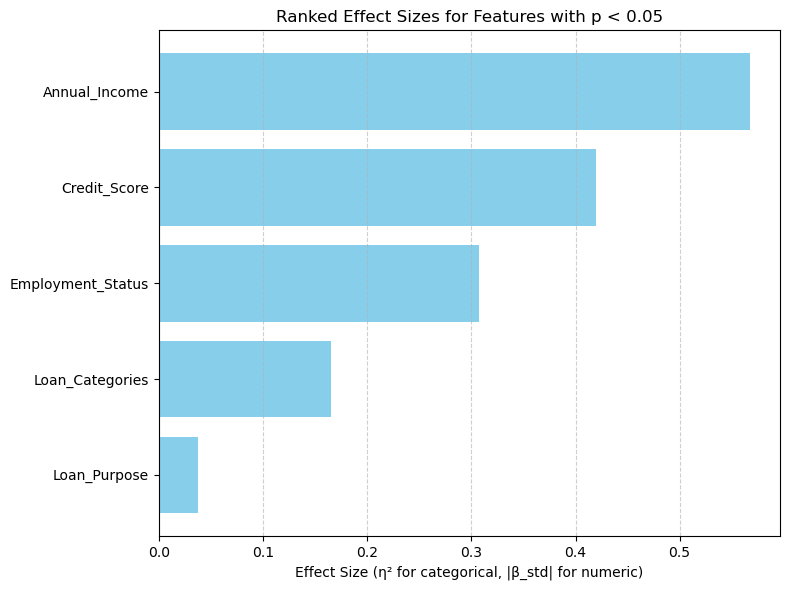

In [48]:
plt.figure(figsize=(8, 6))
plt.barh(eff_df['Feature'], eff_df['Effect_Size'], color='skyblue')
plt.xlabel("Effect Size (η² for categorical, |β_std| for numeric)")
plt.title("Ranked Effect Sizes for Features with p < 0.05")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [50]:
def compute_metrics(GT, R):
    # True Positives, False Positives, False Negatives
    TP = GT & R
    FP = R - GT
    FN = GT - R
    
    # Counts
    tp, fp, fn = len(TP), len(FP), len(FN)
    
    # Metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / len(GT) if len(GT) > 0 else 0
    fdr = fp / (tp + fp) if (tp + fp) > 0 else 0
    
    return {
        'TP': TP, 'FP': FP, 'FN': FN,
        'Precision': precision,
        'Recall': recall,
        'FDR': fdr
    }


GT = {"annual_income", "credit_score","Employment_Status","Loan_Categories","Loan_Purpose"}
R  = {"annual_income",
        "credit_score",
        "Employment_Status",
        "Loan_Categories",
        "Loan_Purpose"}

In [52]:
metrics = compute_metrics(GT, R)

In [54]:
print("True Positives (TP):", metrics['TP'])
print("False Positives (FP):", metrics['FP'])
print("False Negatives (FN):", metrics['FN'])
print(f"Precision: {metrics['Precision']:.3f}")
print(f"Recall:    {metrics['Recall']:.3f}")
print(f"FDR:       {metrics['FDR']:.3f}")

True Positives (TP): {'Loan_Categories', 'credit_score', 'Loan_Purpose', 'annual_income', 'Employment_Status'}
False Positives (FP): set()
False Negatives (FN): set()
Precision: 1.000
Recall:    1.000
FDR:       0.000


In [56]:
#SEM

In [58]:
from semopy import Model
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [60]:
categorical_cols = ['Loan_Purpose', 'Employment_Status', 'Loan_Categories', 'Region', 'Marital_Status']
df_encoded = pd.get_dummies(merged_df, columns=categorical_cols, drop_first=False)
df_encoded.columns = df_encoded.columns.str.replace("-", "_").str.replace(" ", "_")

In [62]:
nums = ['Annual_Income','Credit_Score','Employment_Length','Age','Loan_Term']
scaler = StandardScaler()
df_encoded[nums] = scaler.fit_transform(df_encoded[nums])

In [64]:
model_desc = """
# Measurement model (latent constructs from categorical dummy variables)
LoanPurpose      =~ Loan_Purpose_Car + Loan_Purpose_Home + Loan_Purpose_Personal
EmploymentStatus =~ Employment_Status_Self_employed + Employment_Status_Unemployed + Employment_Status_Employed
LoanCategories   =~ Loan_Categories_Large + Loan_Categories_Medium + Loan_Categories_Small
RegionLatent     =~ Region_South + Region_East + Region_West + Region_North
MaritalStatus    =~ Marital_Status_Divorced + Marital_Status_Married + Marital_Status_Single

# Structural model: all features pointing to Approval_Probability
pred_value ~ Annual_Income + Credit_Score + Employment_Length + Age + Loan_Term + LoanPurpose + EmploymentStatus + LoanCategories + RegionLatent + MaritalStatus
"""



In [66]:
model = Model(model_desc)
model.fit(df_encoded)

SolverResult(fun=18.700827290295496, success=True, n_it=57, x=array([-4.92193055e-01, -4.97721908e-01, -4.84417443e-01, -5.05841372e-01,
       -4.89636709e-01, -5.00300626e-01, -3.23351233e-01, -3.21145924e-01,
       -3.45505984e-01, -4.77948485e-01, -5.12057199e-01,  1.16654740e-01,
        8.68404383e-02, -2.94703961e-03, -1.80940032e-03,  9.38723419e-04,
       -4.42047890e-02,  1.93002183e-01, -1.56122192e-01,  7.49480203e-03,
        6.25655102e-04,  2.21294030e-01, -5.53247068e-03, -7.97410140e-03,
        1.68444334e-01,  4.50565543e-09,  1.68257127e-01,  2.23421842e-01,
        4.20599800e-03,  4.23516463e-03, -5.36435564e-03, -3.90500608e-03,
        2.23623688e-01, -5.32028662e-03, -4.85855909e-03, -1.11214914e-03,
        4.54783675e-09,  1.66855873e-01,  1.66833941e-01,  4.56416322e-09,
        1.66666166e-01,  1.66687980e-01,  2.24181865e-01, -3.53801236e-03,
        4.57536432e-09,  1.66028525e-01,  1.66148274e-01,  1.90015685e-01,
        1.64257367e-01,  1.69671871e-0

In [68]:
std_est = model.inspect(std_est=True)

In [76]:
lhs_col = "lhs" if "lhs" in std_est.columns else "lval"
rhs_col = "rhs" if "rhs" in std_est.columns else "rval"
p_col = "pval" if "pval" in std_est.columns else "p-value"

effect_col = "std_est" if "std_est" in std_est.columns else "Est. Std" 

# Filter: Only regression paths into the output variable
mask = (std_est["op"] == "~") & (std_est[lhs_col] == "pred_value")
results = std_est.loc[mask, [rhs_col, effect_col, p_col]].rename(
    columns={rhs_col: "Feature", effect_col: "EffectSize", p_col: "p_value"}
)

# Rank by absolute effect size
results["abs_effect"] = results["EffectSize"].abs()
results = results.sort_values("abs_effect", ascending=False)

In [78]:
# results = pd.DataFrame(data)
results["abs_effect"] = results["EffectSize"].abs()

# Filter features with p-value < 0.05
significant = results[results["p_value"] < 0.05]

# Sort by effect size for a clean visual
significant = significant.sort_values("abs_effect",ascending = True)

In [80]:
significant

,Feature,EffectSize,p_value,abs_effect
24,RegionLatent,0.015704,0.048047,0.015704
21,LoanPurpose,-0.100484,0.0,0.100484
23,LoanCategories,-0.354729,0.0,0.354729
17,Credit_Score,0.417437,0.0,0.417437
22,EmploymentStatus,0.436431,0.0,0.436431
16,Annual_Income,0.560753,0.0,0.560753


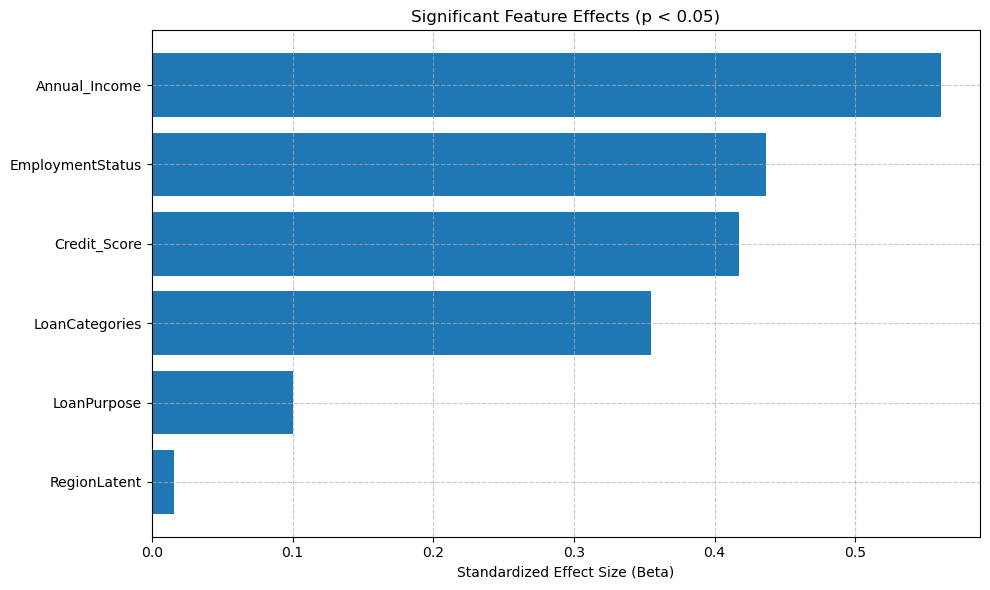

In [82]:
plt.figure(figsize=(10, 6))
plt.barh(significant["Feature"], significant["abs_effect"])
plt.xlabel("Standardized Effect Size (Beta)")
plt.title("Significant Feature Effects (p < 0.05)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [84]:
def compute_metrics(GT, R):
    # True Positives, False Positives, False Negatives
    TP = GT & R
    FP = R - GT
    FN = GT - R
    
    # Counts
    tp, fp, fn = len(TP), len(FP), len(FN)
    
    # Metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / len(GT) if len(GT) > 0 else 0
    fdr = fp / (tp + fp) if (tp + fp) > 0 else 0
    
    return {
        'TP': TP, 'FP': FP, 'FN': FN,
        'Precision': precision,
        'Recall': recall,
        'FDR': fdr
    }


GT = {"annual_income", "credit_score","Employment_Status","Loan_Categories","Loan_Purpose"}
R  = {"annual_income",
        "Employment_Status",
        "credit_score",
        "Loan_Categories",
        "Loan_Purpose",
        "RegionLatent"}

In [86]:
metrics = compute_metrics(GT, R)

In [88]:

print("True Positives (TP):", metrics['TP'])
print("False Positives (FP):", metrics['FP'])
print("False Negatives (FN):", metrics['FN'])
print(f"Precision: {metrics['Precision']:.3f}")
print(f"Recall:    {metrics['Recall']:.3f}")
print(f"FDR:       {metrics['FDR']:.3f}")

True Positives (TP): {'Loan_Categories', 'credit_score', 'Loan_Purpose', 'annual_income', 'Employment_Status'}
False Positives (FP): {'RegionLatent'}
False Negatives (FN): set()
Precision: 0.833
Recall:    1.000
FDR:       0.167


In [25]:
import shap
import numpy as np
import psutil
import os
import torch.optim as optim
import matplotlib.pyplot as plt

In [74]:
X_train_num  = scaler.transform(train_df[num_feats])
X_test_num   = scaler.transform(test_df[num_feats])
y_train      = train_df[target].values.astype(float)
y_test       = test_df[target].values.astype(float)
X_train_cat  = train_df[cat_feats].values.astype(int)
X_test_cat   = test_df[cat_feats].values.astype(int)

In [76]:
# X_train_all = np.hstack([X_train_num, X_train_cat])
# X_test_all  = np.hstack([X_test_num,  X_test_cat])


In [27]:
X_train_all = np.hstack([train_num, train_df[cat_feats].values])  # (n_train, 10)
X_test_all  = np.hstack([test_num,  test_df[cat_feats].values])   # (n_test,  10)


In [62]:
feature_name = num_feats + cat_feats

In [29]:
feature_names = (
    num_feats +
    [f"{col}_{lvl}" for col in cat_feats for lvl in cat_categories[col]]
)

In [31]:
def predict_regression(x_np):
    """
    x_np: np.array of shape (batch, D=10)
      first 5 columns = scaled numerics
      next 5 columns = integer codes
    returns: (batch,) continuous outputs
    """
    x_num = torch.from_numpy(x_np[:, :len(num_feats)]).float().to(device)
    x_cat = torch.from_numpy(x_np[:, len(num_feats):].astype(int)).long().to(device)
    model.eval()
    with torch.no_grad():
        out = model(x_num, x_cat).cpu().numpy().flatten()
    return out

In [33]:
bg_size    = 200
bg_inds    = np.random.choice(len(X_train_all), size=bg_size, replace=False)
background = X_train_all[bg_inds]

In [35]:
explainer = shap.KernelExplainer(predict_regression, background)


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [37]:
all_shap = []
batch_size = 512
for i in range(0, len(X_test_all), batch_size):
    Xb = X_test_all[i : i + batch_size]
    sv = explainer.shap_values(Xb, nsamples=100)  # → (batch, 10)
    all_shap.append(sv)

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/440 [00:00<?, ?it/s]

In [41]:
all_shap_values = np.vstack(all_shap)     

In [45]:
feature_names

['Annual_Income',
 'Credit_Score',
 'Employment_Length',
 'Age',
 'Loan_Term',
 'Loan_Purpose_Car',
 'Loan_Purpose_Home',
 'Loan_Purpose_Personal',
 'Employment_Status_Employed',
 'Employment_Status_Self-employed',
 'Employment_Status_Unemployed',
 'Loan_Categories_Large',
 'Loan_Categories_Medium',
 'Loan_Categories_Small',
 'Region_East',
 'Region_North',
 'Region_South',
 'Region_West',
 'Marital_Status_Divorced',
 'Marital_Status_Married',
 'Marital_Status_Single']

In [64]:
mean_abs_enc = pd.Series(
    np.abs(all_shap_values).mean(axis=0),
    index=feature_name
)

In [68]:
mean_orig_sorted = mean_abs_enc.sort_values(ascending=False)

In [70]:
mean_orig_sorted

Annual_Income        0.108402
Employment_Status    0.100812
Credit_Score         0.087452
Loan_Categories      0.073041
Loan_Purpose         0.029732
Loan_Term            0.002381
Employment_Length    0.001626
Region               0.001549
Marital_Status       0.001098
Age                  0.000779
dtype: float64

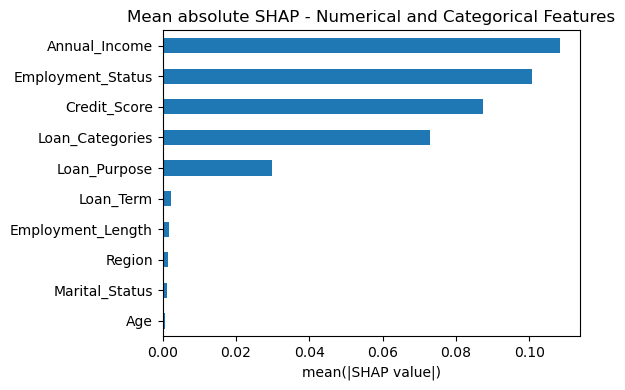

In [76]:
os.makedirs("shap", exist_ok=True)
plt.figure(figsize=(6,4))
mean_orig_sorted.plot.barh()
plt.xlabel("mean(|SHAP value|)")
plt.title("Mean absolute SHAP - Numerical and Categorical Features")
plt.gca().invert_yaxis()
plt.tight_layout()
out_path = os.path.join("shap", "Transformer_numerical categorical_regression_test_shap_summary.jpg")
plt.savefig(out_path, format="jpg", dpi=300)
plt.show()

In [80]:
def compute_metrics(GT, R):
    # True Positives, False Positives, False Negatives
    TP = GT & R
    FP = R - GT
    FN = GT - R
    
    # Counts
    tp, fp, fn = len(TP), len(FP), len(FN)
    
    # Metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / len(GT) if len(GT) > 0 else 0
    fdr = fp / (tp + fp) if (tp + fp) > 0 else 0
    
    return {
        'TP': TP, 'FP': FP, 'FN': FN,
        'Precision': precision,
        'Recall': recall,
        'FDR': fdr
    }


GT = {"annual_income", "credit_score","Employment_Status","Loan_Categories","Loan_Purpose"}
R  = {"annual_income",
        "Employment_Status",
        "credit_score",
        "Loan_Categories",
        "Loan_Purpose",
      "Loan_Term",
      "Employment_Length",
        "Region",
     "Marital_Status",
    "Age" }

In [82]:
metrics = compute_metrics(GT, R)
print("True Positives (TP):", metrics['TP'])
print("False Positives (FP):", metrics['FP'])
print("False Negatives (FN):", metrics['FN'])
print(f"Precision: {metrics['Precision']:.3f}")
print(f"Recall:    {metrics['Recall']:.3f}")
print(f"FDR:       {metrics['FDR']:.3f}")

True Positives (TP): {'Loan_Purpose', 'Employment_Status', 'credit_score', 'annual_income', 'Loan_Categories'}
False Positives (FP): {'Loan_Term', 'Age', 'Employment_Length', 'Marital_Status', 'Region'}
False Negatives (FN): set()
Precision: 0.500
Recall:    1.000
FDR:       0.500
